```
RM01/0006     503
RM01/0007     573
RM01/0004     672
RM01/0001    1507

Earliest data of Amonia: 2014-12-01
```

In [ ]:
!pip install fredapi

## Data preparation

In [3]:
import preprocessor as pre
import naiveforecastor as nf
import visualiser as visual
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Import data
gas_df = pre.get_Fred_data('PNGASEUUSDM',2014,2024)
wheat_df = pre.get_Fred_data('PWHEAMTUSDM',2014,2024)
ammonia_df = pre.get_Fred_data('WPU0652013A',2014,2024)
elec_df = pre.clean_elec_csv('Data_flat_files/ELECTRICITY_03_2024.csv',2014,2024)

df = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Predicting_Price_Evolutions_202310.csv',2014,2023)

# Impute raw data of target variables 
imputed_df, missing = pre.impute_pred_price_evo_csv(df)

# Slice date range for Naice Forecast
naive_df = imputed_df[imputed_df.Year >= 2016]


## 1-Month Prediction

### Naive 1-month

MAPE of 1 month(s) acid Naive Forecast: 0.078
MSE of 1 month(s) acid Naive Forecast: 0.019


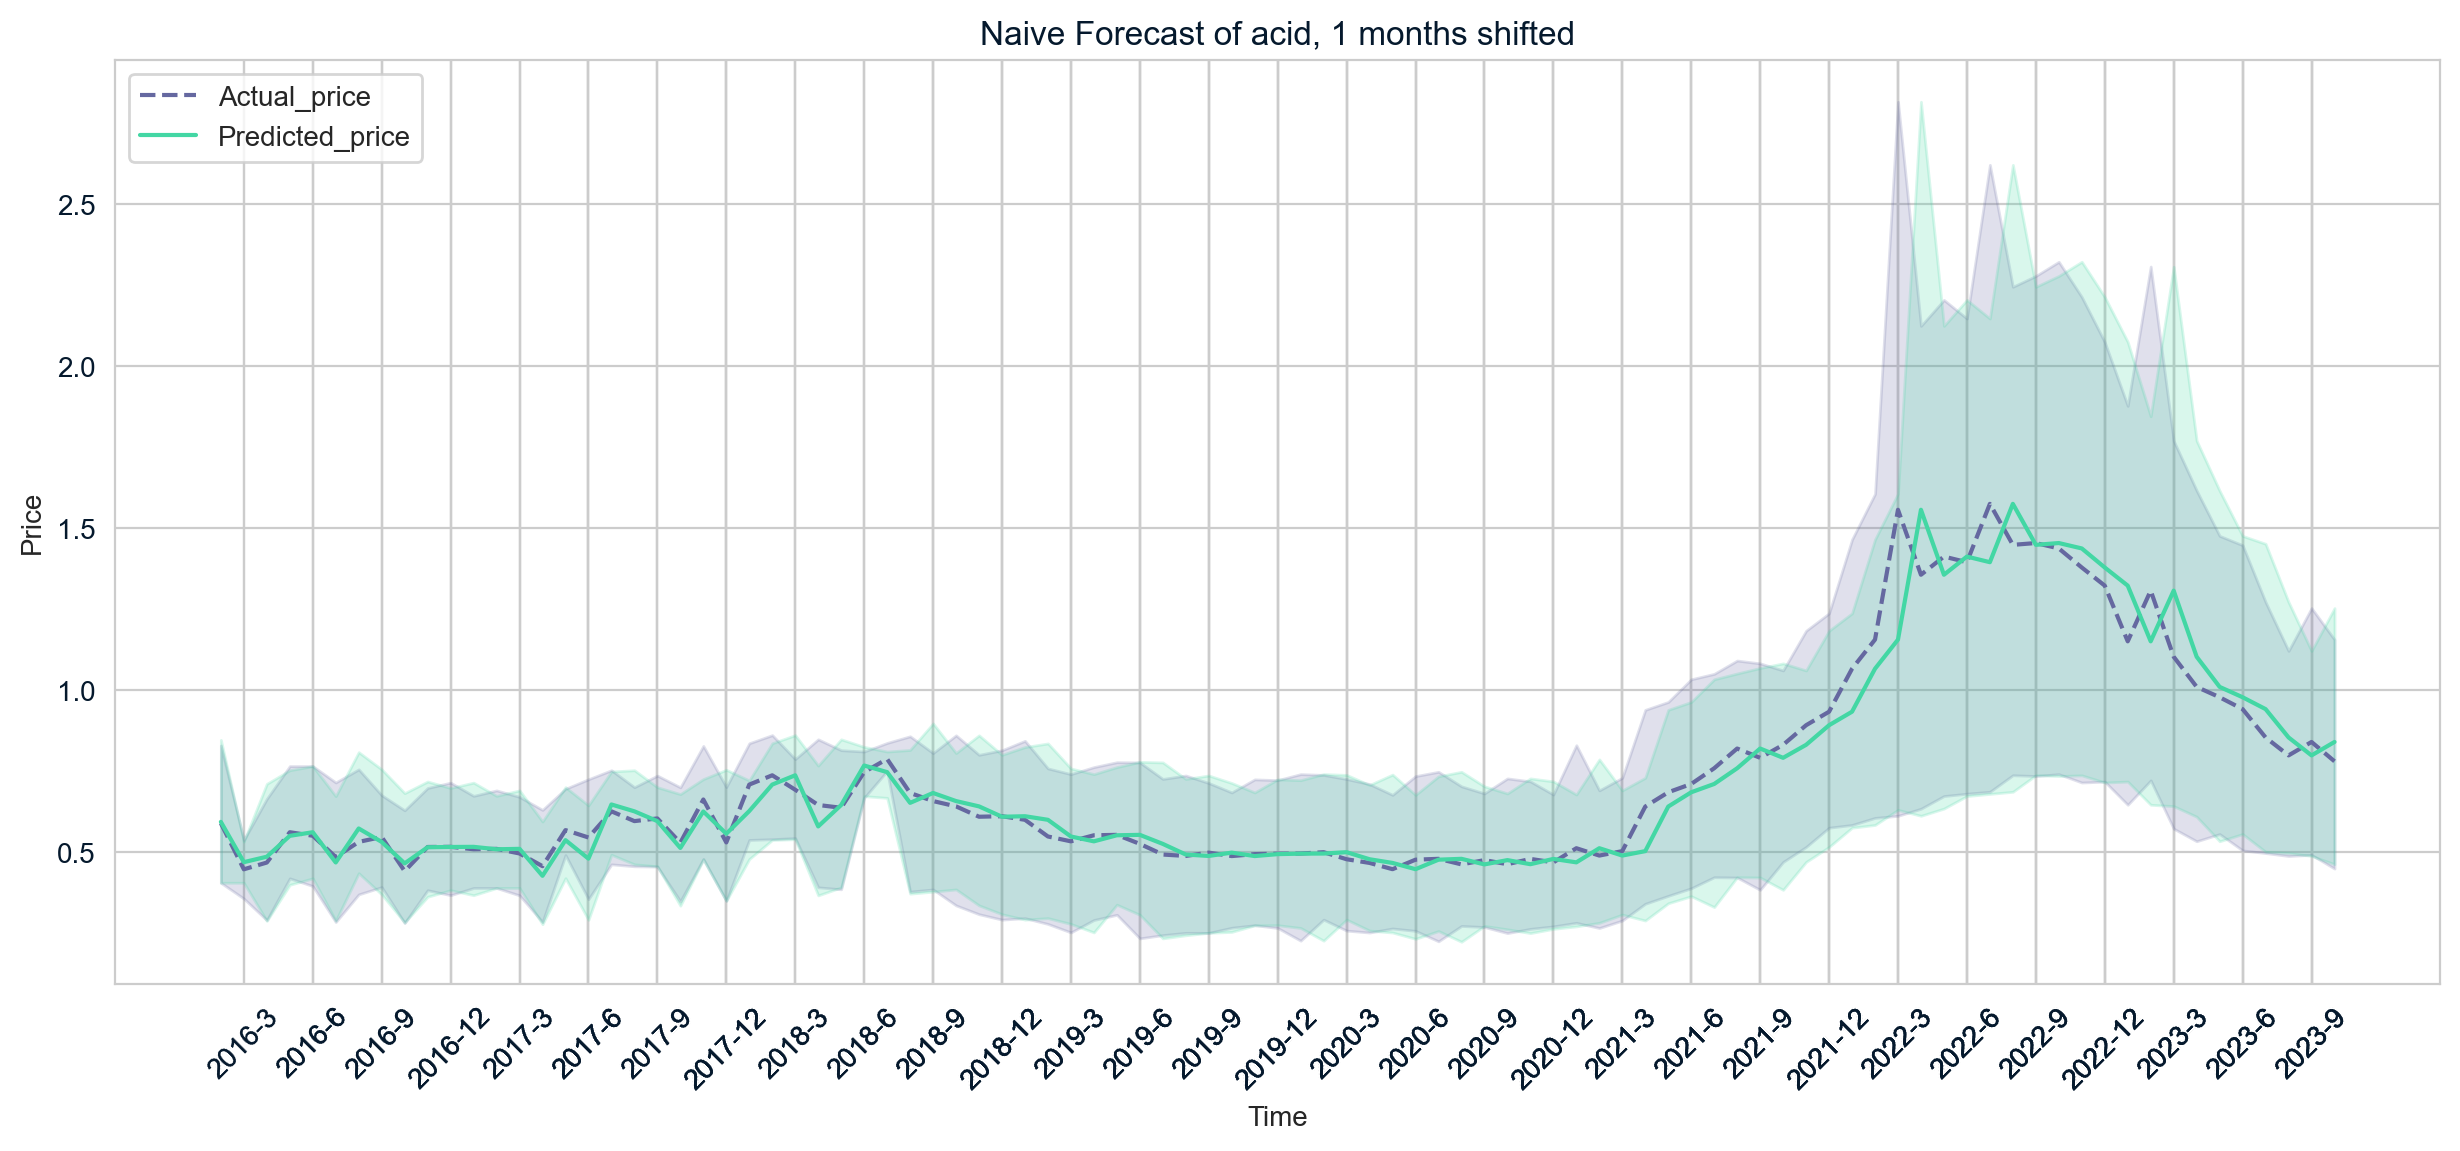

In [4]:
# Naive forecast
nf.naive_forest(naive_df,'acid',1,missing)




### Lasso 1-month

In [6]:
# Create dummy variables
dummy_df = pre.get_dummies_and_average_price(imputed_df,'acid',\
                                         'RM01/0001','RM01/0004','RM01/0006','RM01/0007')

# Generate features
acid_df = pre.generate_features(1,12,dummy_df,\
                                 'RM01/0001',\
                                 'RM01/0004',\
                                 'RM01/0006',\
                                 'RM01/0007',\
                                PNGASEUUSDM=gas_df,\
                                PWHEAMTUSDM=wheat_df,\
                                WPU0652013A=ammonia_df,\
                                Electricity=elec_df
                               )

acid_df = acid_df[acid_df.Year >= 2016]

<class 'pandas.core.frame.DataFrame'>
Index: 870 entries, 73 to 1177
Data columns (total 68 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   RM01/0004          870 non-null    bool          
 1   RM01/0006          870 non-null    bool          
 2   RM01/0007          870 non-null    bool          
 3   Year               870 non-null    float64       
 4   Month              870 non-null    float64       
 5   Time               870 non-null    datetime64[ns]
 6   Group Description  870 non-null    object        
 7   Average_price      870 non-null    float64       
 8   PNGASEUUSDM_1      870 non-null    float64       
 9   PWHEAMTUSDM_1      870 non-null    float64       
 10  WPU0652013A_1      870 non-null    float64       
 11  Electricity_1      870 non-null    float64       
 12  PNGASEUUSDM_2      870 non-null    float64       
 13  PWHEAMTUSDM_2      870 non-null    float64       
 14  WPU0652013A_2

In [7]:
## train_test_split()
## Check data distribution
## Data scaling - log transformation and standardlisation

# Create X, y
feature_list = acid_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = acid_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% as test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [10]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)



# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")
    
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_
    
# Calculate MAPE and MSE of training set
y_pred_train = best_lasso_model.predict(X_train_scaled)
y_pred_train_inverse = np.exp(scaler_y.inverse_transform(y_pred_train.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

print("MAPE, 1-month, train: ", round(mean_absolute_percentage_error(y_train,y_pred_train_inverse), 3))
print("MSE, 1-month, train: ", round(mean_squared_error(y_train,y_pred_train_inverse), 3))

Best alpha parameter: 1e-07
Best R-squared score: 0.943
Coefficients of the selected features in the best Lasso model:
RM01/0004: -0.053
RM01/0006: 0.184
RM01/0007: -0.561
PNGASEUUSDM_1: 0.02
PWHEAMTUSDM_1: -0.017
WPU0652013A_1: 0.151
Electricity_1: -0.117
PNGASEUUSDM_2: 0.105
PWHEAMTUSDM_2: 0.132
WPU0652013A_2: -0.263
Electricity_2: 0.048
PNGASEUUSDM_3: 0.373
PWHEAMTUSDM_3: 0.311
WPU0652013A_3: -0.093
Electricity_3: -0.35
PNGASEUUSDM_4: -0.065
PWHEAMTUSDM_4: -0.119
WPU0652013A_4: 0.471
Electricity_4: -0.362
PNGASEUUSDM_5: 0.568
PWHEAMTUSDM_5: -0.046
WPU0652013A_5: -0.432
Electricity_5: 0.152
PNGASEUUSDM_6: 0.005
PWHEAMTUSDM_6: -0.124
WPU0652013A_6: -0.459
Electricity_6: 0.052
PNGASEUUSDM_7: 0.319
PWHEAMTUSDM_7: 0.309
WPU0652013A_7: -0.223
Electricity_7: 0.127
PNGASEUUSDM_8: -0.119
PWHEAMTUSDM_8: -0.093
WPU0652013A_8: 0.073
Electricity_8: -0.159
PNGASEUUSDM_9: 0.367
PWHEAMTUSDM_9: 0.166
WPU0652013A_9: -0.073
Electricity_9: -0.183
PNGASEUUSDM_10: -0.018
PWHEAMTUSDM_10: -0.156
WPU0652013

In [11]:
## Lasso regression - transform test data set
# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)
y_pred_test_inverse = np.exp(scaler_y.inverse_transform(y_pred_test.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

# Calculate MAPE
print("MAPE, 1-month, test: ", round(mean_absolute_percentage_error(y_test,y_pred_test_inverse), 3))

# Best mean_squared_error
print("MSE, 1-month, test: ", round(mean_squared_error(y_test,y_pred_test_inverse), 3))

Best Model: Lasso(alpha=1e-07)
Test Set R-squared score: 0.949
MAPE, 1-month, test:  0.103
MSE, 1-month, test:  0.02


In [12]:
## Lasso regression - transform new data and match the predicted values with real values
# Get latest data

df_24 = pre.clean_pred_price_evo_csv('Data_flat_files/Dataset_Future_Predicting_Price_Evolutions_202403.csv',2014,2024)

imputed_df_24, missing_24 = pre.impute_pred_price_evo_csv(df_24)

dummy_df_24 = pre.get_dummies_and_average_price(imputed_df_24,'acid',\
                                         'RM01/0001','RM01/0004','RM01/0006','RM01/0007')

acid_df_24 = pre.generate_features(1,12,dummy_df_24,\
                                   'RM01/0001',\
                                   'RM01/0004',\
                                   'RM01/0006',\
                                   'RM01/0007',\
                                   PNGASEUUSDM=gas_df,\
                                   PWHEAMTUSDM=wheat_df,\
                                   WPU0652013A=ammonia_df,\
                                   Electricity=elec_df)

# Create X, y
feature_list = acid_df_24.drop(['Time', 'Group Description','Year','Month','Average_price'],\
                                  axis=1)
X_24 = feature_list
y_24 = acid_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

# Predict new y
y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1) # the model was trained with log-transformed and standardlised y

# Calculate MAPE
mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f"MAPE, 1-month, new data: {mape_24:.3f}")
mse_24 = mean_squared_error(y_24,y_pred_24_inverse)
# Best mean_squared_error
print(f"MSE, 1-month, new data: {mse_24:.3f}")

MAPE, 1-month, new data: 0.107
MSE, 1-month, new data: 0.022


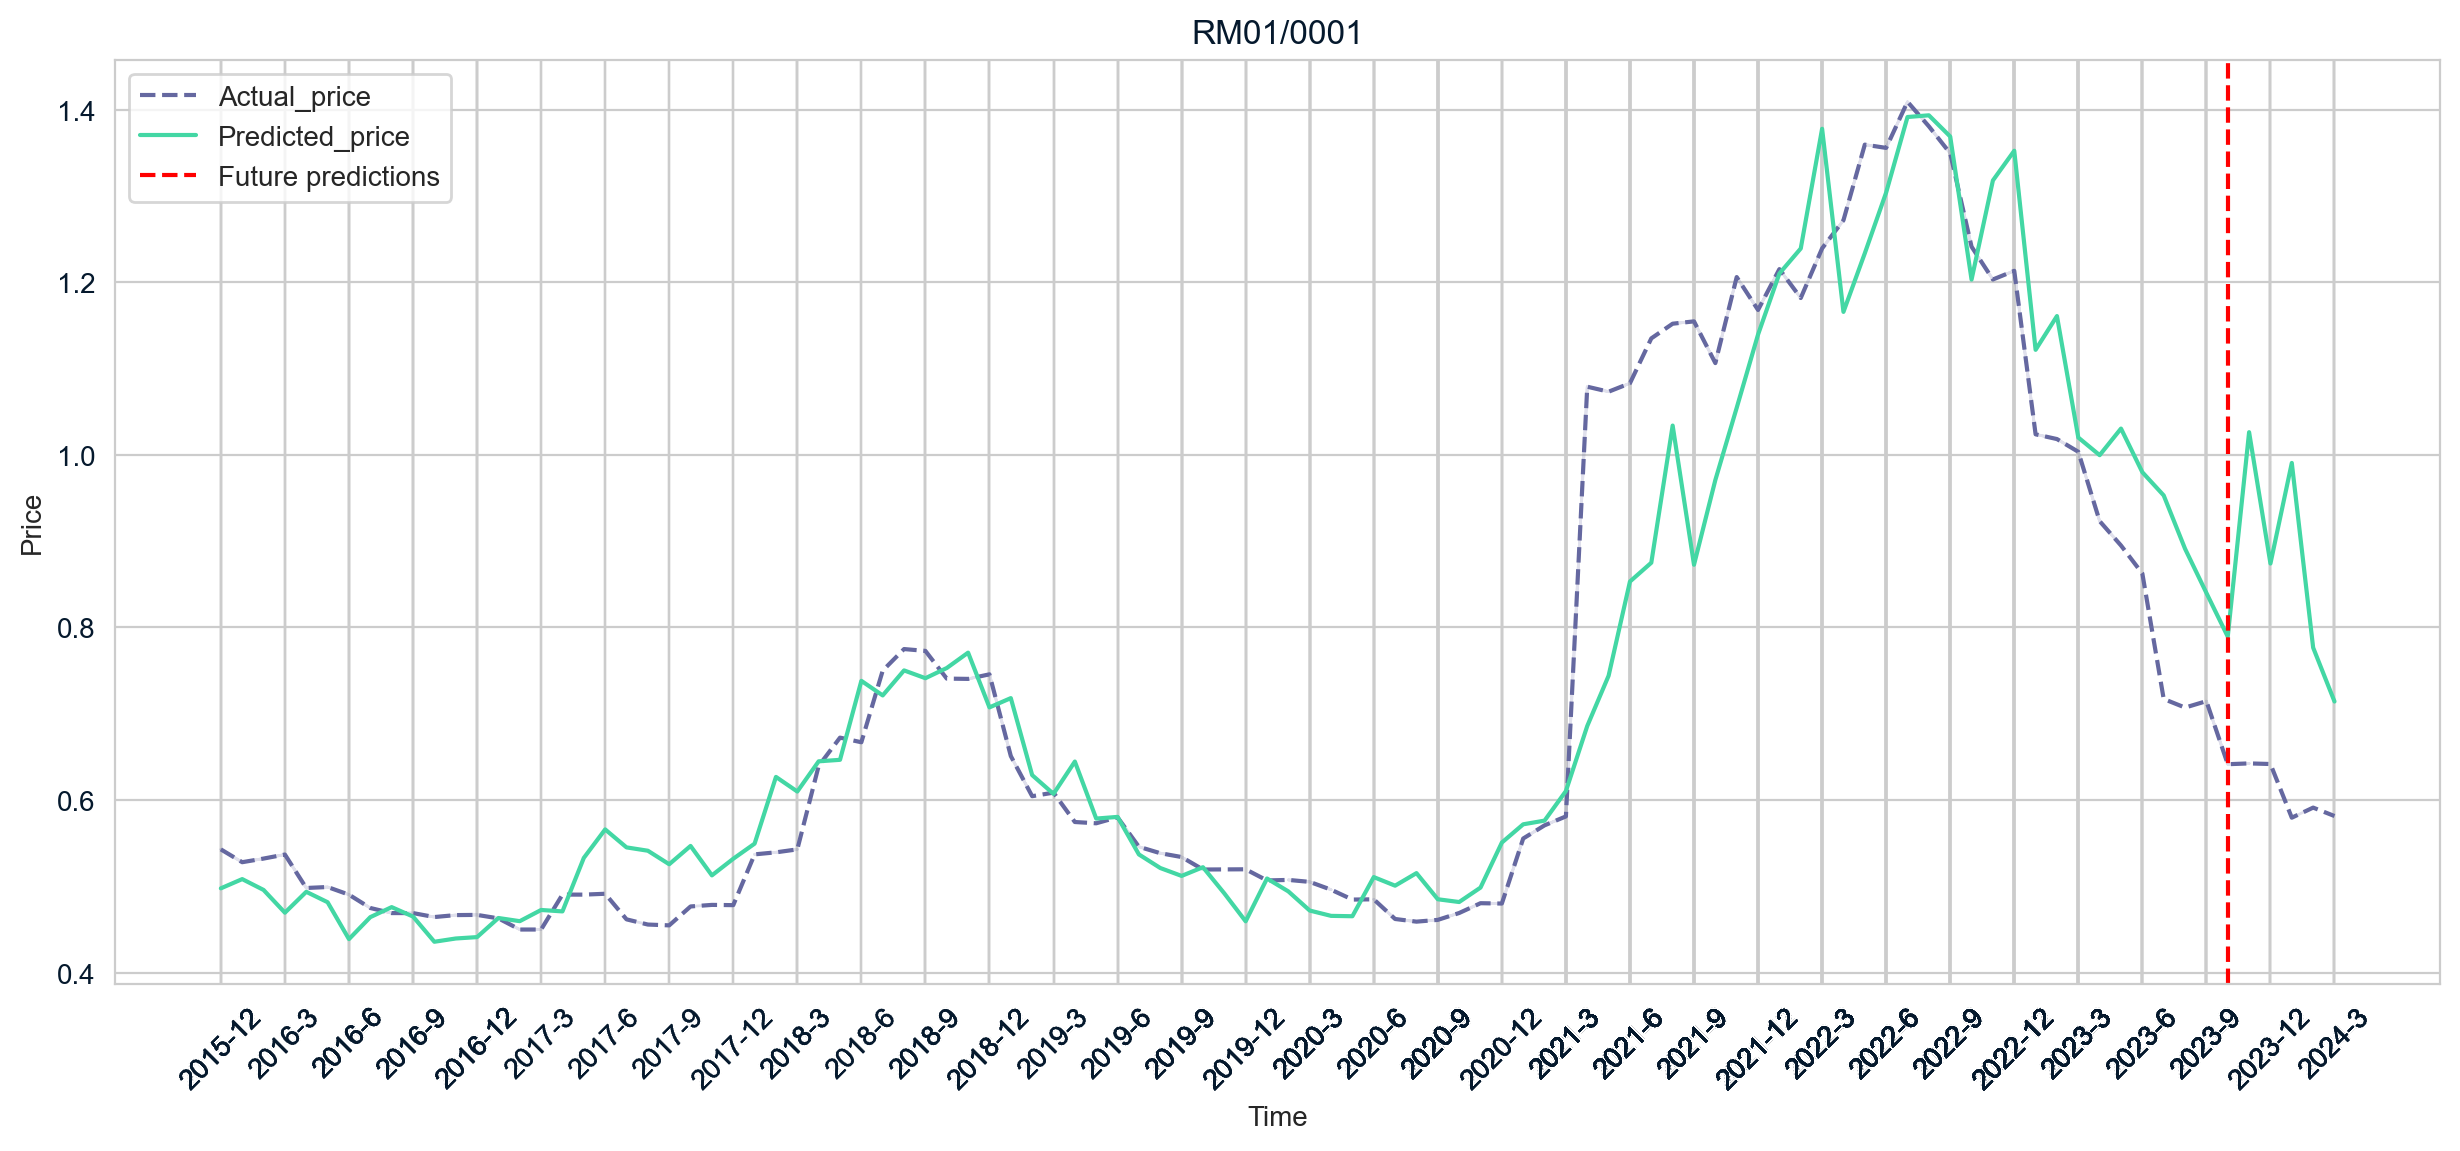

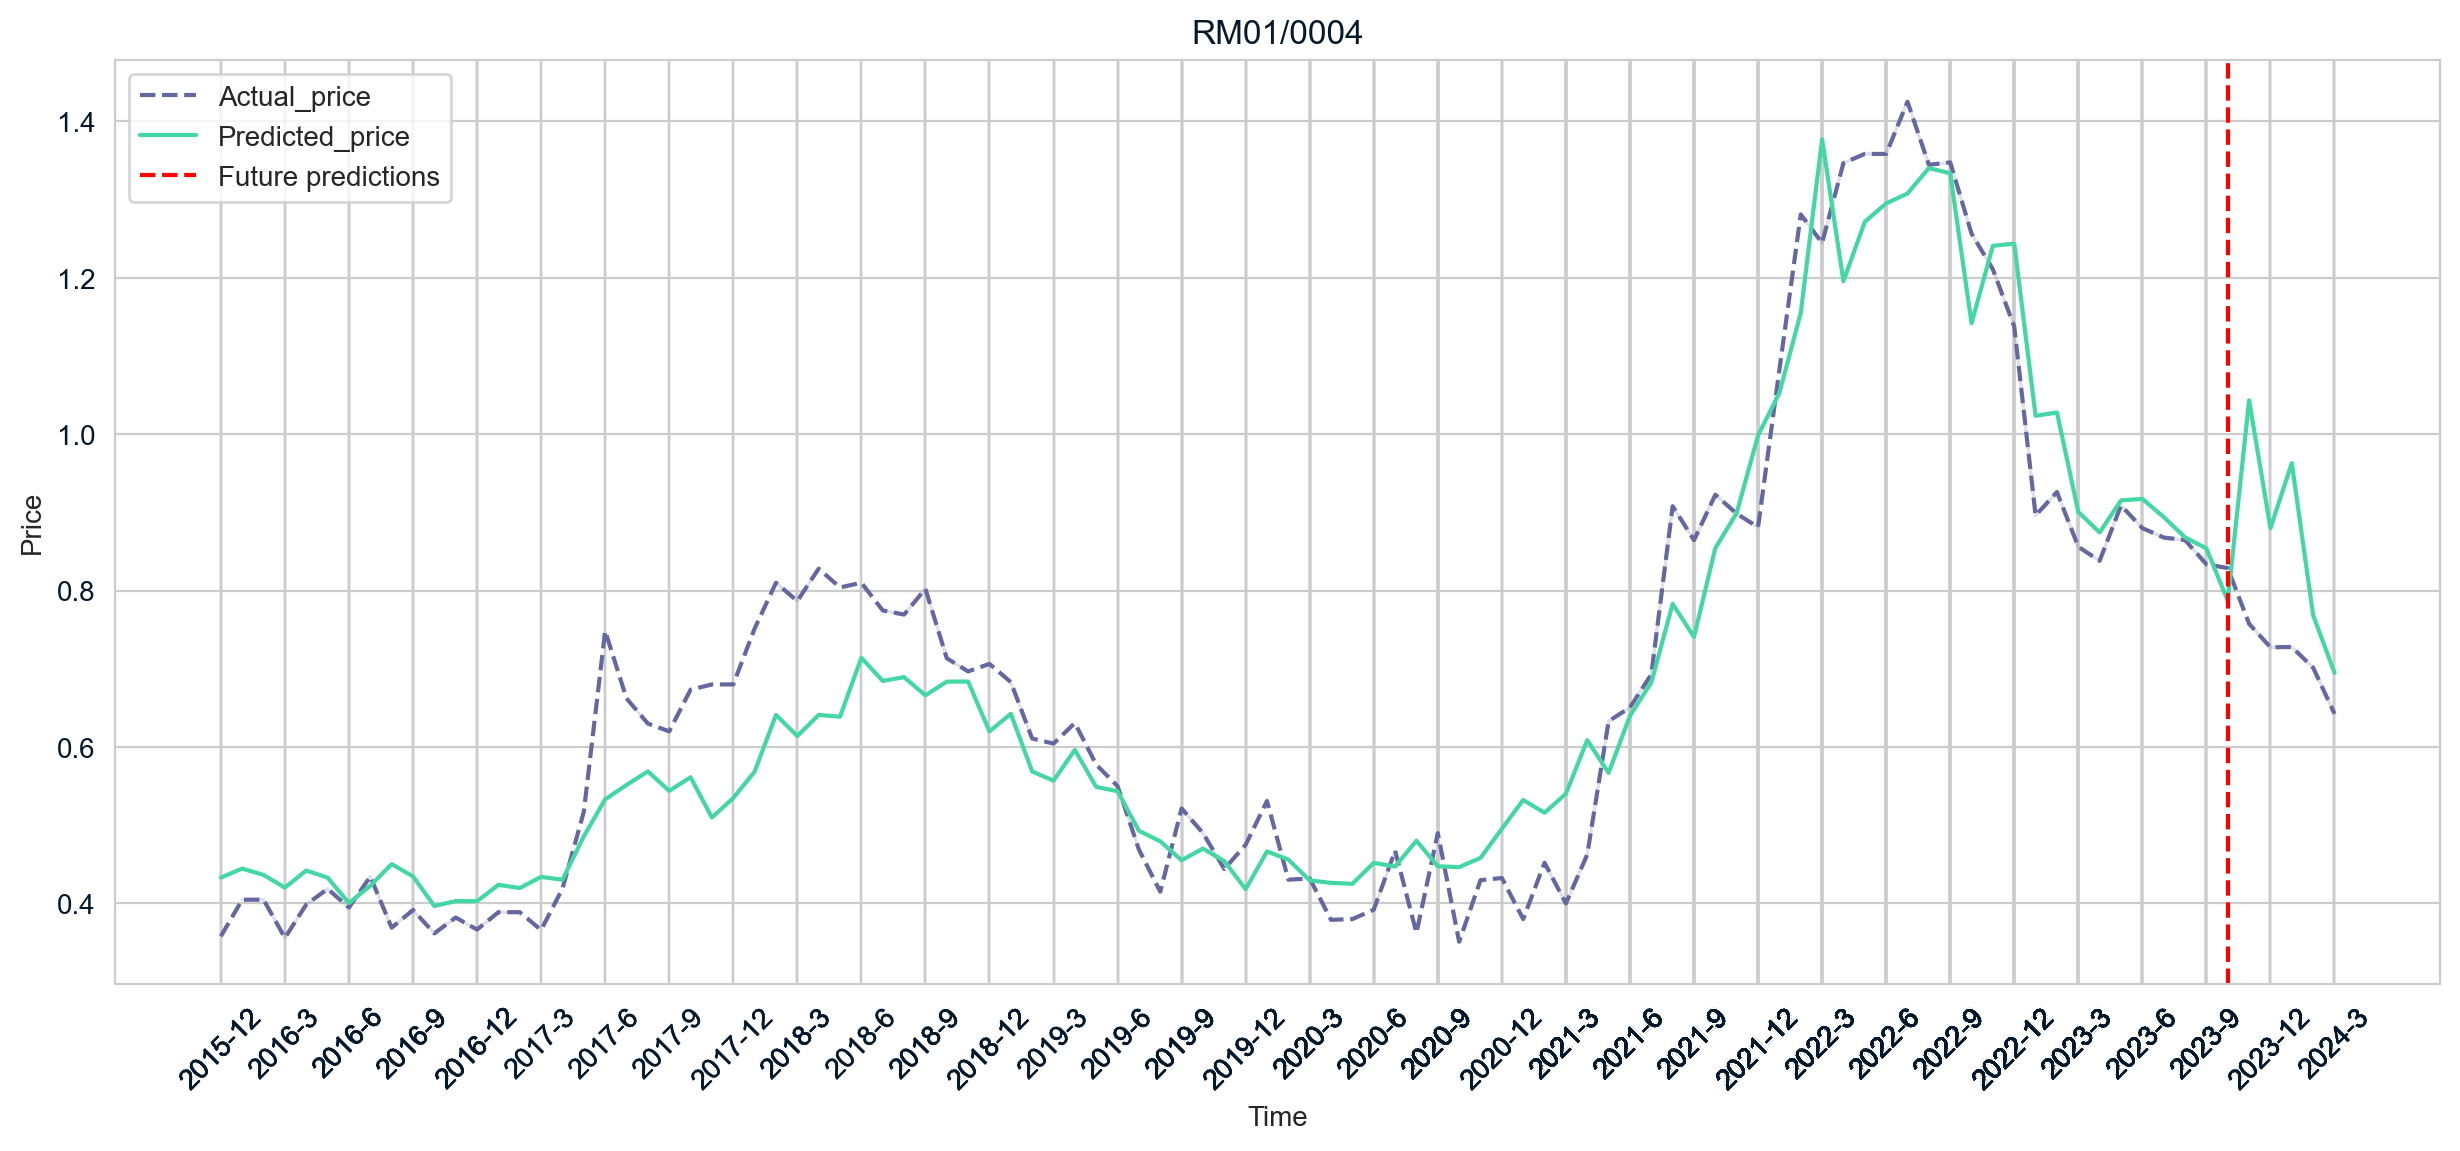

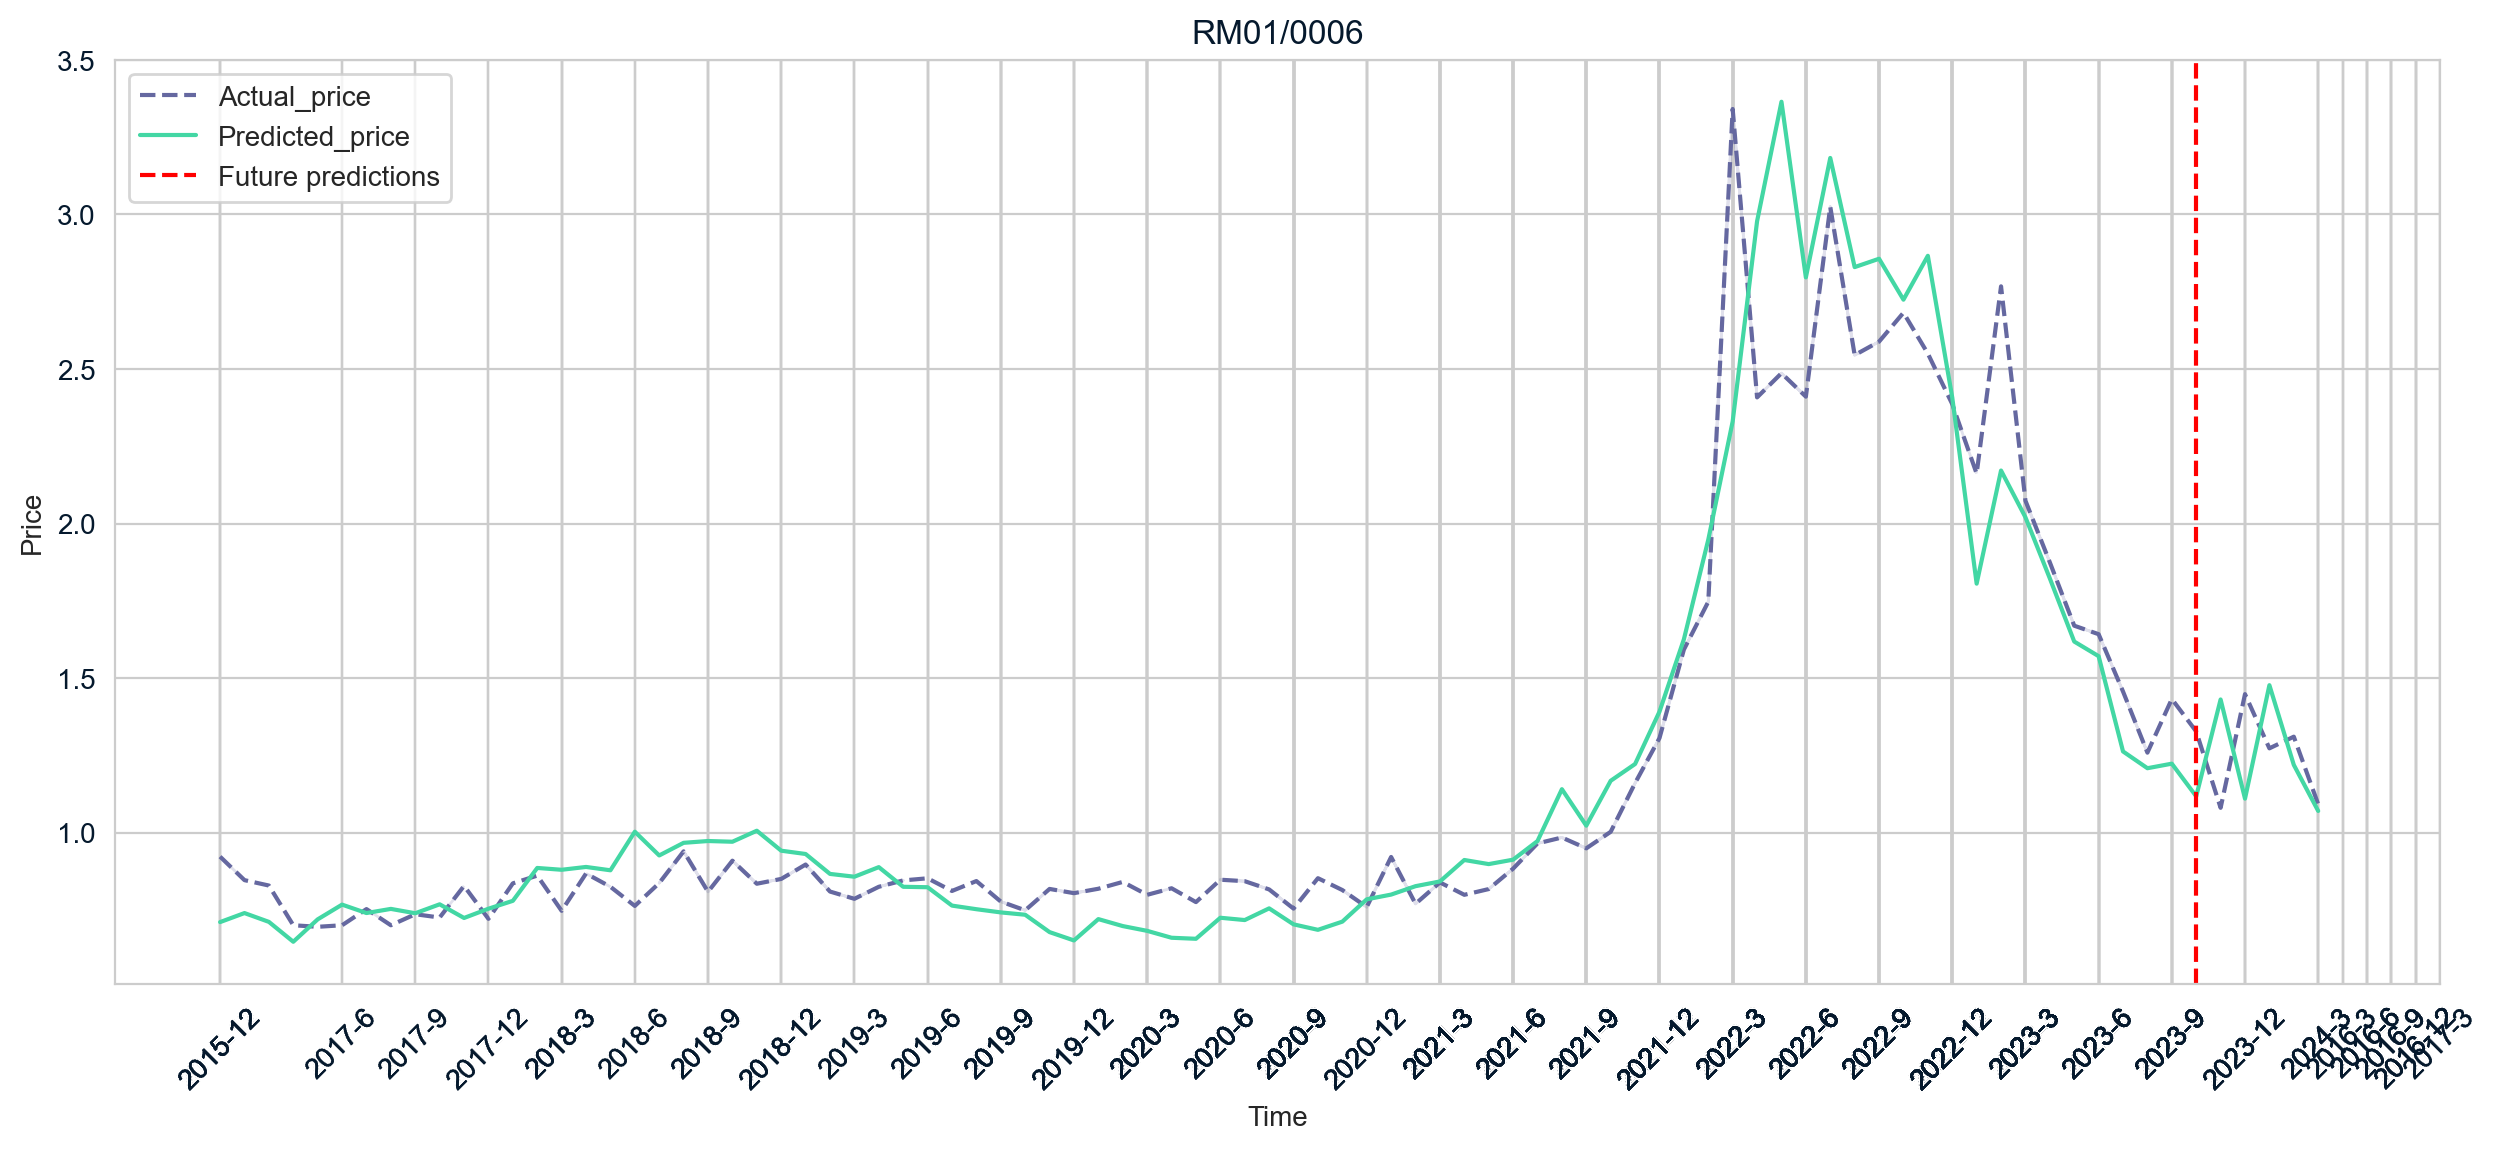

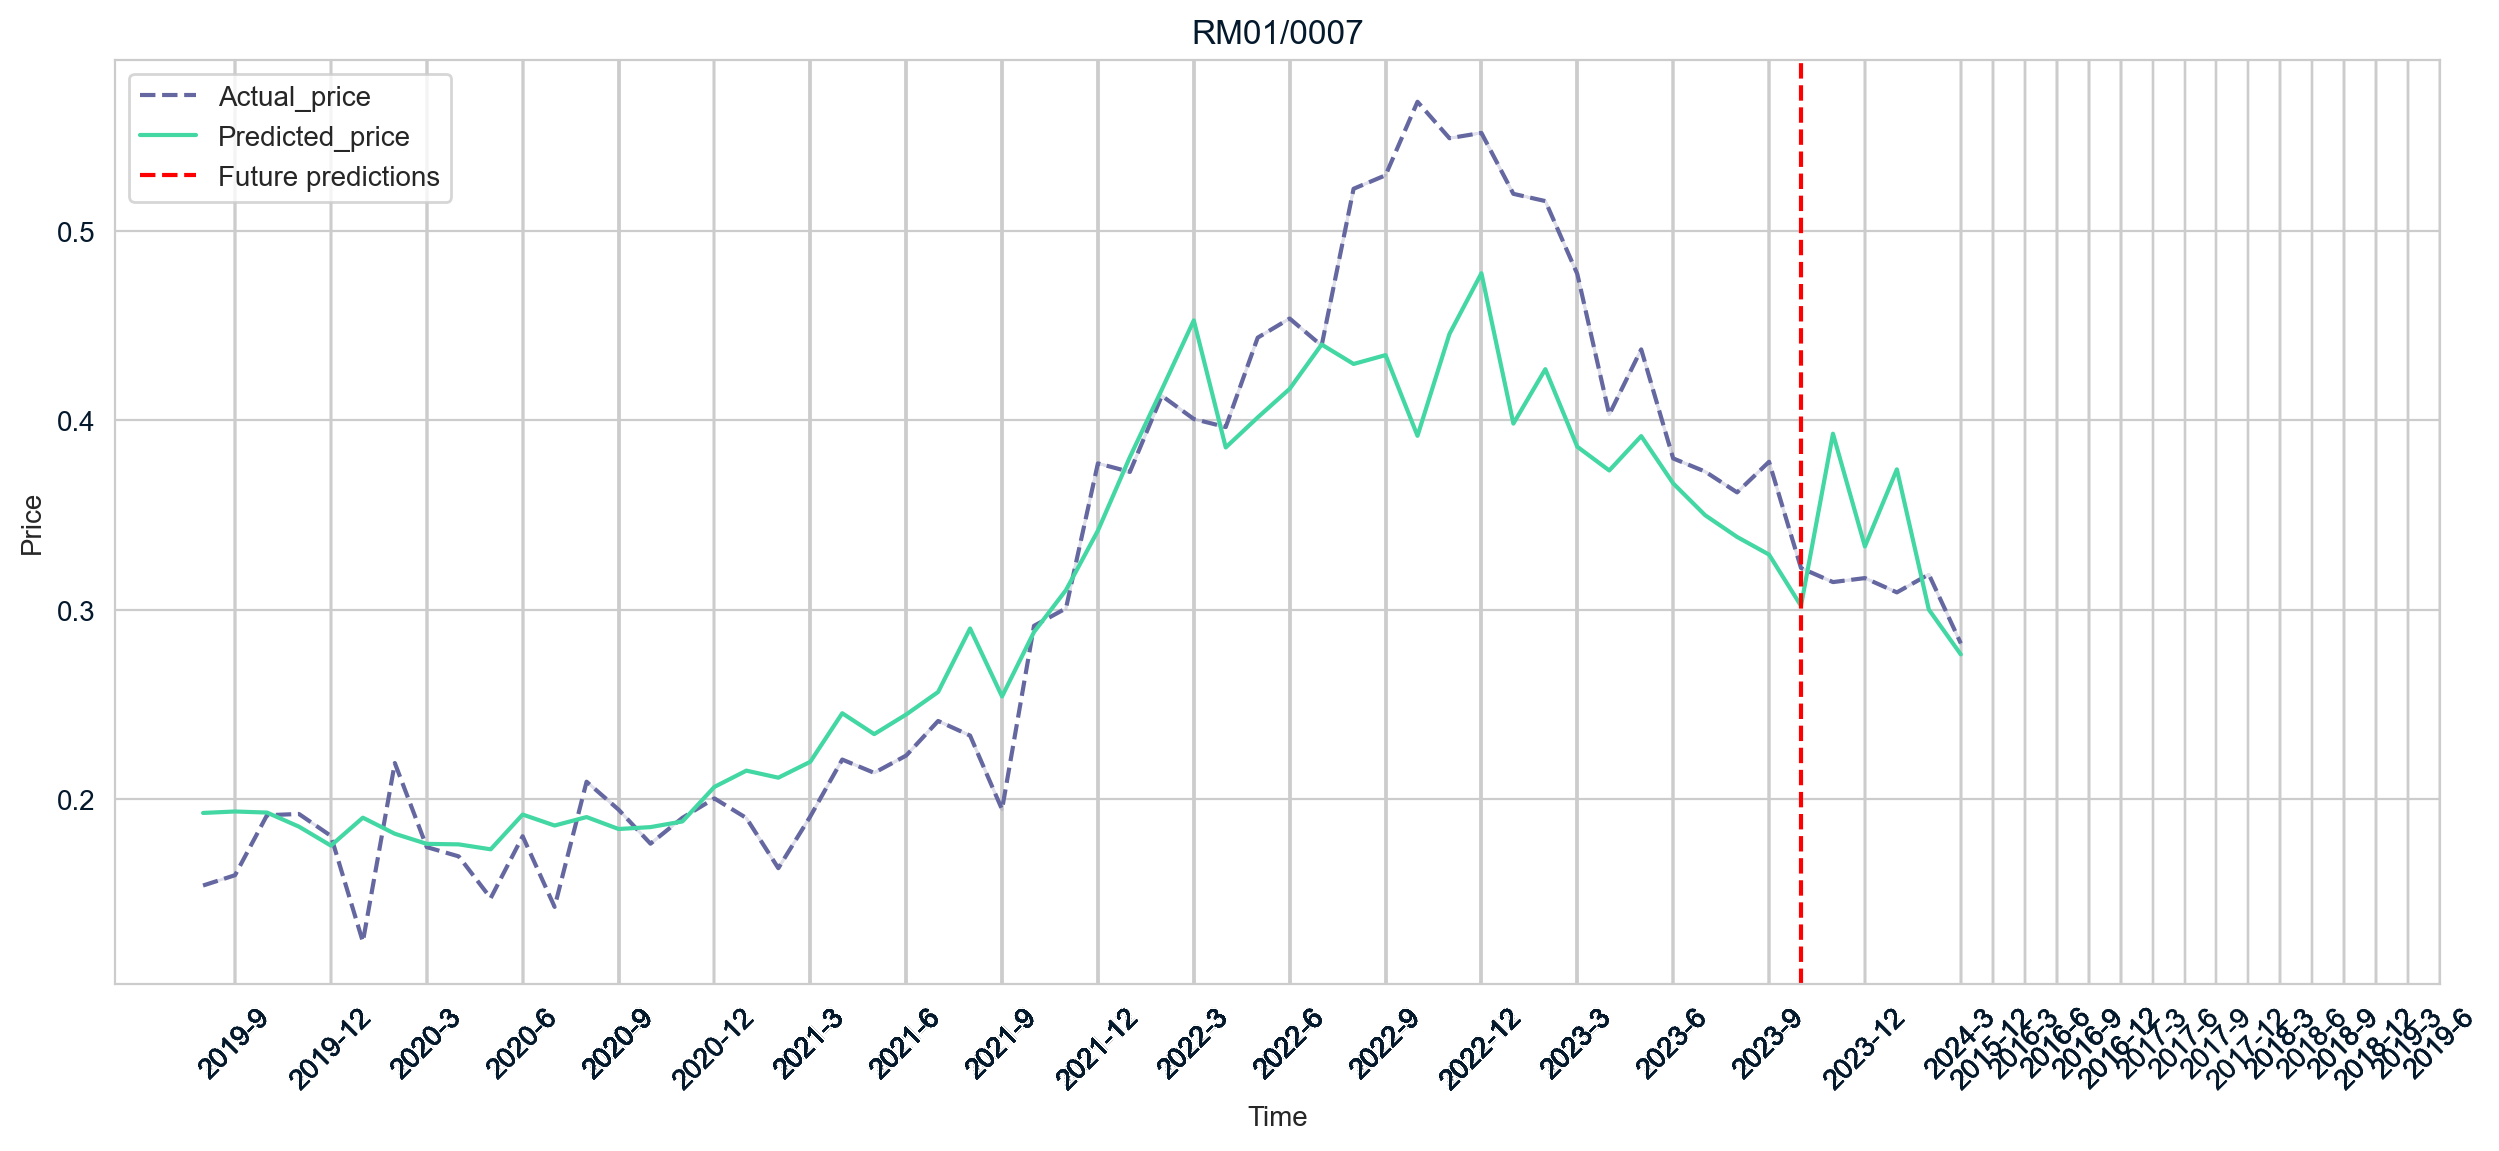

In [13]:
## Visualisation
# To match the predicted values with original df
acid_df_24['Predictions'] = y_pred_24_inverse

acid_df_24['year_month'] = acid_df_24['Year'].apply(round).astype('str') + "-" + acid_df_24['Month'].apply(round).astype('str')

# Visualisation
visual.draw_graph(acid_df_24,'year_month','Average_price','Predictions','2023-10','RM01/0001', 'RM01/0004', 'RM01/0006', 'RM01/0007')

## 2 months predictions